
# Entrega Final — Entrenamiento y Optimización de Modelos de Machine Learning  
**Proyecto:** Calidad del Vino (Tintos y Blancos)  
**Autor:** Claudia Benitez  

## Abstracto — Motivación y Audiencia
Este proyecto utiliza modelos de Machine Learning para predecir la calidad del vino a partir de variables fisicoquímicas.
La audiencia principal incluye enólogos, responsables de calidad y analistas del sector alimenticio.



## Problema de Machine Learning
El problema se modela como una **clasificación binaria**:
- 1: Vino de buena calidad (quality ≥ 7)
- 0: Vino de calidad baja o media



## Instalación de Librerías
En este paso importo las librerías necesarias para el análisis, visualización y modelado. Cada librería cumple un rol específico: pandas y numpy para manipulación de datos, matplotlib para visualizaciones y sklearn para entrenamiento y evaluación de modelos.
- pandas / numpy: análisis de datos  
- matplotlib / seaborn: visualización  
- scikit-learn: modelos y validación  
- xgboost: boosting  
- shap: interpretabilidad



In [10]:

!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap joblib --quiet



In [11]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
sns.set_style("whitegrid")
%matplotlib inline



## Carga de Datos desde GitHub


In [12]:

red_wine = pd.read_csv(
    "https://raw.githubusercontent.com/ClauBenitez/datasciencestest/refs/heads/main/winequality-red.csv",
    sep=";"
)

white_wine = pd.read_csv(
    "https://raw.githubusercontent.com/ClauBenitez/datasciencestest/refs/heads/main/winequality-white.csv",
    sep=";"
)

red_wine["type"] = "red"
white_wine["type"] = "white"

df = pd.concat([red_wine, white_wine], axis=0).reset_index(drop=True)
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red



## Análisis Exploratorio de Datos (EDA)

En esta sección realizo un análisis exploratorio para comprender la estructura del dataset, la distribución de las variables y la variable objetivo. Este paso me permite detectar posibles problemas antes del modelado.


In [13]:

df.describe().T


,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


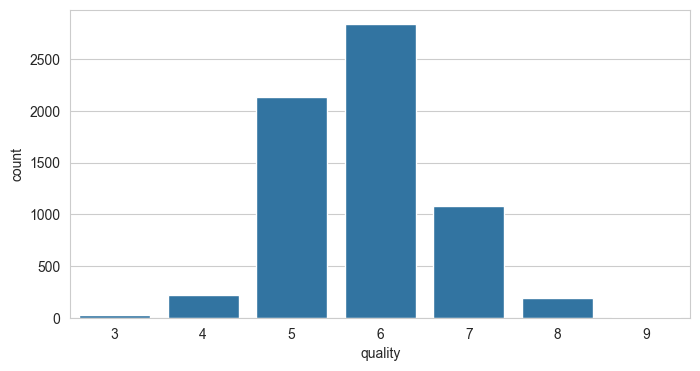

In [14]:

plt.figure(figsize=(8,4))
sns.countplot(x="quality", data=df)
plt.show()



## Ingeniería de Atributos
En este paso preparo los datos para el modelado. Defino la variable objetivo, realizo la ingeniería de atributos necesaria y separo los datos en conjuntos de entrenamiento y prueba.

In [15]:

df["quality_binary"] = (df["quality"] >= 7).astype(int)
df_encoded = pd.get_dummies(df, columns=["type"], drop_first=True)

X = df_encoded.drop(columns=["quality", "quality_binary"])
y = df_encoded["quality_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)



## Entrenamiento y Validación de Modelos
Aquí entreno distintos modelos de Machine Learning con el objetivo de comparar su desempeño. Utilizo validación cruzada para asegurar una evaluación robusta.

In [16]:

models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")
    print(name, scores.mean())


LogisticRegression 0.8076440029316633
RandomForest 0.9105890272926649


c:\Users\clbenitez\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\clbenitez\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\clbenitez\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\clbenitez\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:27] W

XGBoost 0.8913678189036862


c:\Users\clbenitez\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



## Optimización de Hiperparámetros (Random Forest)
En esta etapa aplico técnicas de optimización para mejorar el rendimiento del modelo seleccionado, ajustando sus hiperparámetros mediante GridSearch.

In [17]:

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="roc_auc"
)

grid.fit(X_train, y_train)
grid.best_params_


{'max_depth': None, 'n_estimators': 200}

## Evaluación Final del Modelo

Finalmente evalúo el mejor modelo utilizando métricas adecuadas y analizo sus resultados para determinar su utilidad práctica.

In [18]:

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Accuracy: 0.8861538461538462
AUC: 0.9131990283571844
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1306
           1       0.80      0.55      0.66       319

    accuracy                           0.89      1625
   macro avg       0.85      0.76      0.79      1625
weighted avg       0.88      0.89      0.88      1625




## Guardado del Modelo


In [19]:

import os
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/wine_quality_model.pkl")


['models/wine_quality_model.pkl']


## Conclusiones
El modelo Random Forest optimizado fue el que presentó mejor desempeño.


## Limpieza y Calidad de los Datos

Antes de avanzar con el análisis, verifiqué la calidad del dataset. No se detectaron valores faltantes ni inconsistencias, por lo que no fue necesario aplicar imputaciones o eliminar registros.

## Métricas de Evaluación

Se utilizaron Accuracy y AUC. La métrica AUC fue priorizada por su capacidad de evaluar la discriminación del modelo independientemente del umbral.

## Aplicación Práctica del Modelo

El modelo puede utilizarse como soporte a la toma de decisiones en procesos productivos para anticipar posibles desviaciones de calidad.

## Consideraciones Éticas y Limitaciones

El modelo no reemplaza el criterio humano y refleja evaluaciones subjetivas. Debe utilizarse como apoyo y validarse periódicamente.